In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

no_of_games = 17

In [2]:
def pull_db(query,db_name):
    # Connect to your SQLite database
    conn = sqlite3.connect(db_name)  # Replace with your actual database file name


    # Execute the query and read the results into a DataFrame
    df = pd.read_sql_query(query, conn)

    # Close the database connection
    conn.close()
    
    return df

if __name__ == '__main__':
    
    #db_name = r'NFL_stats\database\2023_database.db'
    db_name = r'database\2023_database.db'

    query = '''
    SELECT players.Player, players.Pos, receiving.Rec, receiving.Tgts, receiving.TD, receiving.Yds, receiving."20+", receiving."40+", receiving."Rec FUM", receiving."Rec YAC/R", teams.team_name
    FROM players
    INNER JOIN teams ON players.Team = teams.team_id
    INNER JOIN receiving ON players.player_id = receiving.Player;
    '''
    receiving_df = pull_db(query,db_name)
    print(receiving_df.sort_values(by='TD', ascending=False))

    positions_query = '''
    SELECT POS, pos_id
    FROM positions;
    '''
    positions_df = pull_db(positions_query, db_name)
    print(positions_df)

    print("Script complete")
    
    
    #LEFT JOIN IS INCLUSIVE OFF ALL RESULTS

               Player  Pos  Rec  Tgts  TD   Yds  20+  40+  Rec FUM  Rec YAC/R  \
226       Tyreek Hill    2  119   171  13  1799   29    9        1        652   
338        Mike Evans    2   79   136  13  1255   20    6        0        322   
96        CeeDee Lamb    2  135   181  12  1749   29    3        3        680   
116       Sam LaPorta   14   86   120  10   889    8    2        0        358   
233    Jordan Addison    2   70   107  10   911   15    3        0        262   
..                ...  ...  ...   ...  ..   ...  ...  ...      ...        ...   
246    Kayshon Boutte    2    2     7   0    19    0    0        0         10   
247   Demario Douglas    2   49    79   0   561    6    2        1        336   
58     DeAndre Carter    2    4     7   0    39    0    0        0         50   
249      Kevin Harris    6    3     3   0    58    1    1        0         59   
57   Khari Blasingame    6    3     6   0     2    0    0        0          5   

                team_name  

In [3]:
positions_df

,POS,pos_id
0,G,1
1,WR,2
2,LB,3
3,S,4
4,OT,5
5,RB,6
6,SAF,7
7,LS,8
8,C,9
9,CB,10


In [4]:
receiving_df

,Player,Pos,Rec,Tgts,TD,Yds,20+,40+,Rec FUM,Rec YAC/R,team_name
0,Michael Carter,6,24,31,1,101,0,0,0,87,Arizona Cardinals
1,James Conner,6,27,33,2,165,2,0,0,221,Arizona Cardinals
2,DeeJay Dallas,6,6,9,0,26,0,0,0,31,Arizona Cardinals
3,Emari Demercado,6,21,30,0,119,1,0,0,109,Arizona Cardinals
4,Greg Dortch,2,24,41,2,280,3,0,0,152,Arizona Cardinals
...,...,...,...,...,...,...,...,...,...,...,...
360,Zach Ertz,14,27,43,1,187,0,0,0,46,Washington Commanders
361,Terry McLaurin,2,79,132,4,1002,15,2,0,350,Washington Commanders
362,Brian Robinson,6,36,43,4,368,8,2,1,410,Washington Commanders
363,Cole Turner,14,11,15,0,120,2,0,0,50,Washington Commanders


In [5]:
wr_pos_id = positions_df.loc[positions_df['POS'] == 'WR', 'pos_id'].iloc[0]
wr_receiving_df_parsed = receiving_df[(receiving_df['Tgts'] > 70) & (receiving_df['Pos'] == wr_pos_id)]


In [6]:

from sklearn.cluster import KMeans, MiniBatchKMeans

cluster_df = pd.DataFrame()

cluster_df['Tgts Per Game'] = wr_receiving_df_parsed['Tgts'] / no_of_games
cluster_df['Yds Per Rec'] = wr_receiving_df_parsed['Yds'] / wr_receiving_df_parsed['Rec']



no_of_clusters = 10
model = KMeans(n_clusters=no_of_clusters, n_init='auto').fit(cluster_df)
labels = model.predict(cluster_df)

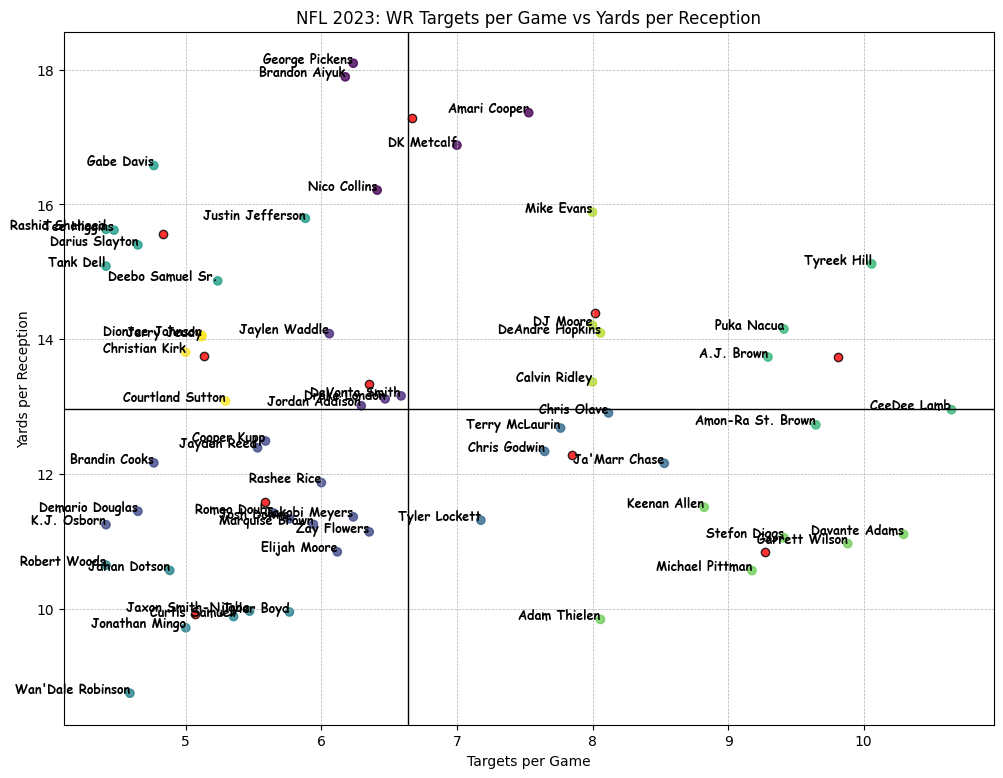

In [15]:
fig, ax = plt.subplots(figsize=(12,9))


x_mean = (wr_receiving_df_parsed['Tgts'] / no_of_games).mean()
y_mean = (wr_receiving_df_parsed['Yds'] / wr_receiving_df_parsed['Rec']).mean()
ax.axvline(x=x_mean, color='black', linestyle='solid', linewidth=1)
ax.axhline(y=y_mean, color='black', linestyle='solid', linewidth=1)

ax.scatter(
    cluster_df['Tgts Per Game'],
    cluster_df['Yds Per Rec'],
    zorder=1,
    alpha= 0.8,
    c=labels
)

ax.scatter(
    model.cluster_centers_[:,0],
    model.cluster_centers_[:,1],
    zorder=1,
    alpha= 0.8,
    c='r',
    edgecolors='black'
)

for index, row in wr_receiving_df_parsed.iterrows():
    plt.text(row['Tgts'] / no_of_games, row['Yds'] / row['Rec'], row['Player'], fontsize=9, ha='right', weight = 'bold', family = 'cursive')



ax.grid(True, which='both', axis='both', linewidth=0.5, linestyle='--')




plt.title('NFL 2023: WR Targets per Game vs Yards per Reception')
plt.xlabel('Targets per Game')
plt.ylabel('Yards per Reception')
plt.show()




Text(0, 0.5, 'Yards per Reception')

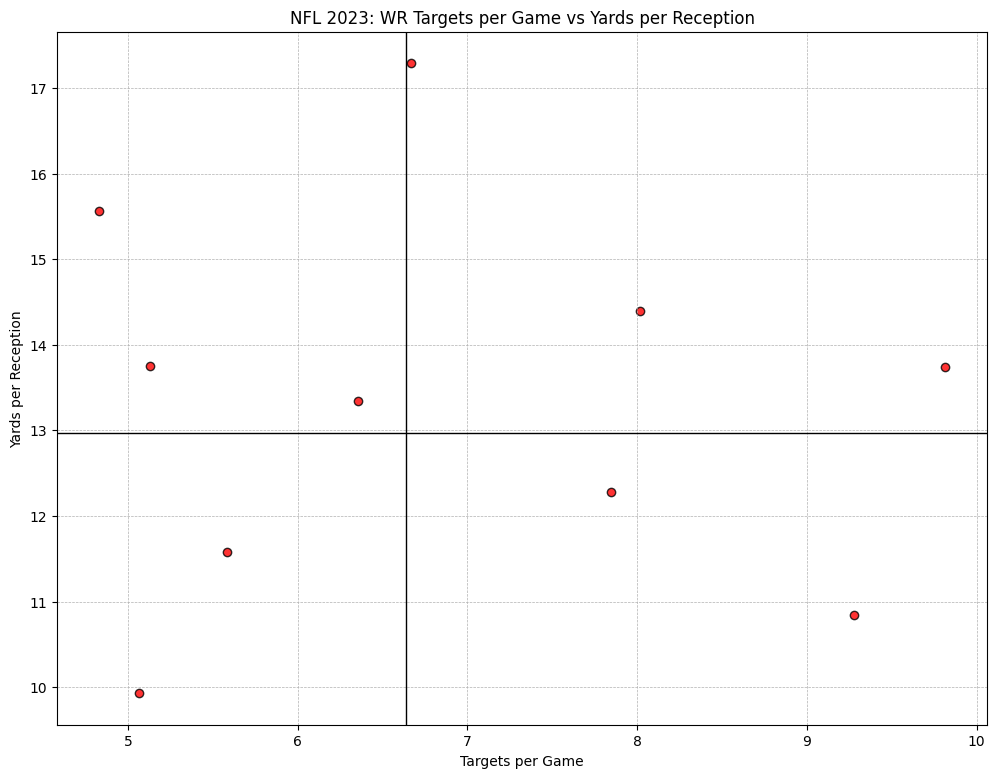

In [8]:
fig, ax = plt.subplots(figsize=(12,9))

ax.scatter(
    model.cluster_centers_[:,0],
    model.cluster_centers_[:,1],
    zorder=1,
    alpha= 0.8,
    c='r',
    edgecolors='black'
)


x_mean = (wr_receiving_df_parsed['Tgts'] / no_of_games).mean()
y_mean = (wr_receiving_df_parsed['Yds'] / wr_receiving_df_parsed['Rec']).mean()
ax.axvline(x=x_mean, color='black', linestyle='solid', linewidth=1)
ax.axhline(y=y_mean, color='black', linestyle='solid', linewidth=1)



ax.grid(True, which='both', axis='both', linewidth=0.5, linestyle='--')

plt.title('NFL 2023: WR Targets per Game vs Yards per Reception')
plt.xlabel('Targets per Game')
plt.ylabel('Yards per Reception')

NameError: name 'wr_recieving_df_parsed' is not defined

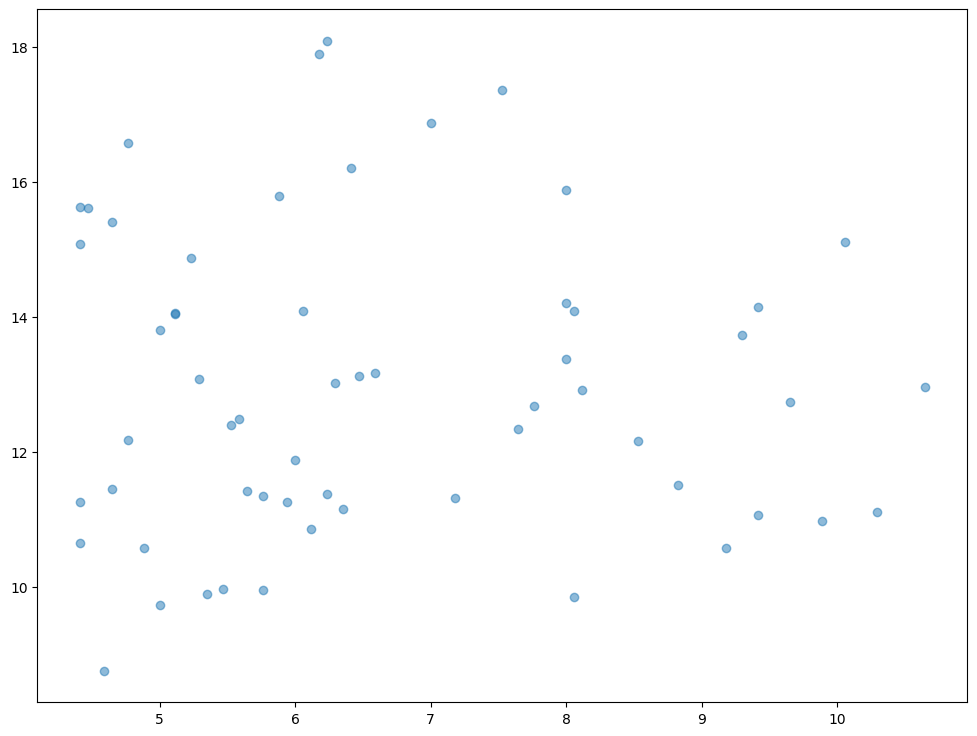

In [9]:
fig, ax = plt.subplots(figsize=(12,9))

ax.scatter(wr_receiving_df_parsed['Tgts'] / 17, wr_receiving_df_parsed['Yds'] / wr_receiving_df_parsed['Rec'], alpha=0.5)

for index, row in wr_recieving_df_parsed.iterrows():
    plt.text(row['Tgts'] / no_of_games, row['Yds'] / row['Rec'], row['Player'], fontsize=9, ha='right')

x_mean = (wr_recieving_df_parsed['Tgts'] / no_of_games).mean()
y_mean = (wr_recieving_df_parsed['Yds'] / wr_recieving_df_parsed['Rec']).mean()
ax.axvline(x=x_mean, color='black', linestyle='solid', linewidth=1)
ax.axhline(y=y_mean, color='black', linestyle='solid', linewidth=1)



ax.grid(True, which='both', axis='both', linewidth=0.5, linestyle='--')

plt.title('NFL 2023: WR Targets per Game vs Yards per Reception')
plt.xlabel('Targets per Game')
plt.ylabel('Yards per Reception')

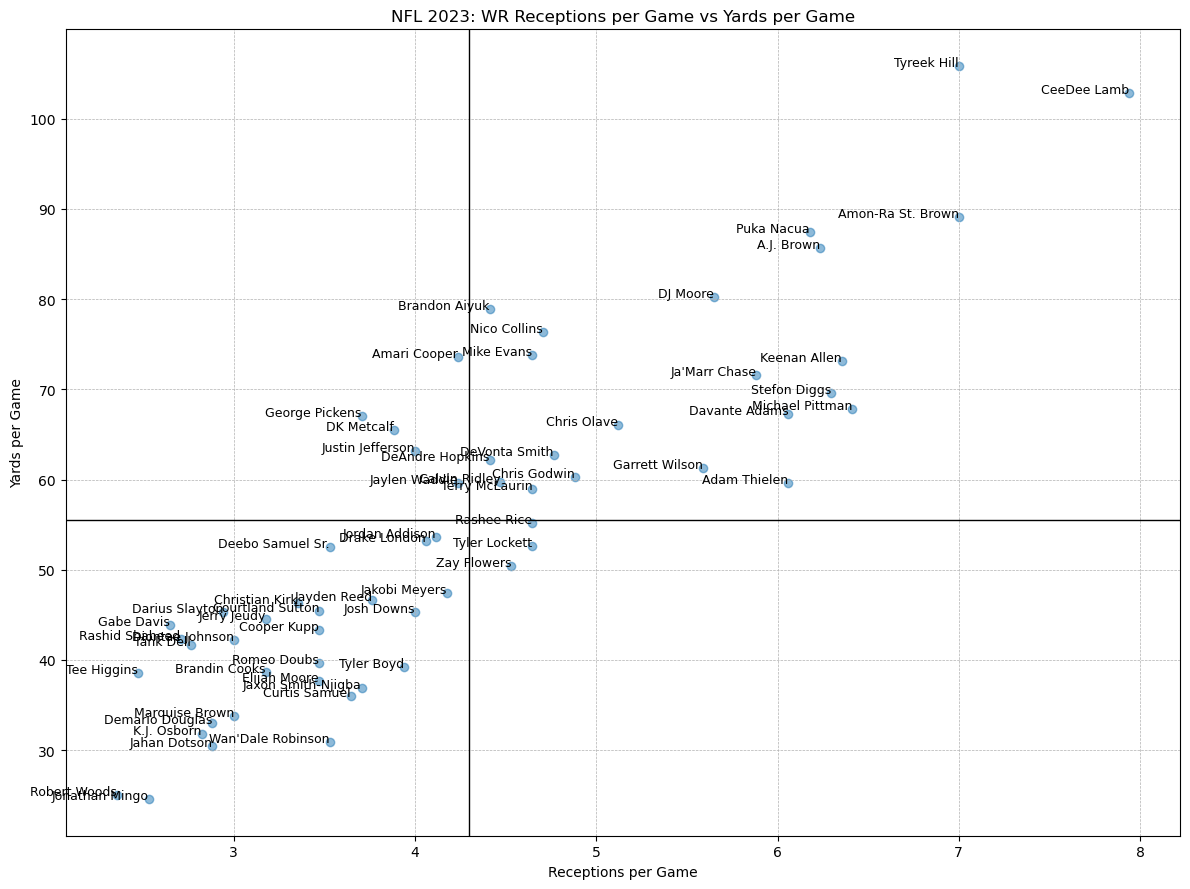

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))

ax.scatter(wr_receiving_df_parsed['Rec'] / 17, wr_receiving_df_parsed['Yds'] / 17, alpha=0.5)

for index, row in wr_recieving_df_parsed.iterrows():
    plt.text(row['Rec'] / 17, row['Yds'] / 17, row['Player'], fontsize=9, ha='right')

x_mean = (wr_recieving_df_parsed['Rec'] / 17).mean()
y_mean = (wr_recieving_df_parsed['Yds'] / 17).mean()
ax.axvline(x=x_mean, color='black', linestyle='solid', linewidth=1)
ax.axhline(y=y_mean, color='black', linestyle='solid', linewidth=1)


ax.grid(True, which='both', axis='both', linewidth=0.5, linestyle='--')

plt.title('NFL 2023: WR Receptions per Game vs Yards per Game')
plt.xlabel('Receptions per Game')
plt.ylabel('Yards per Game')
plt.tight_layout()

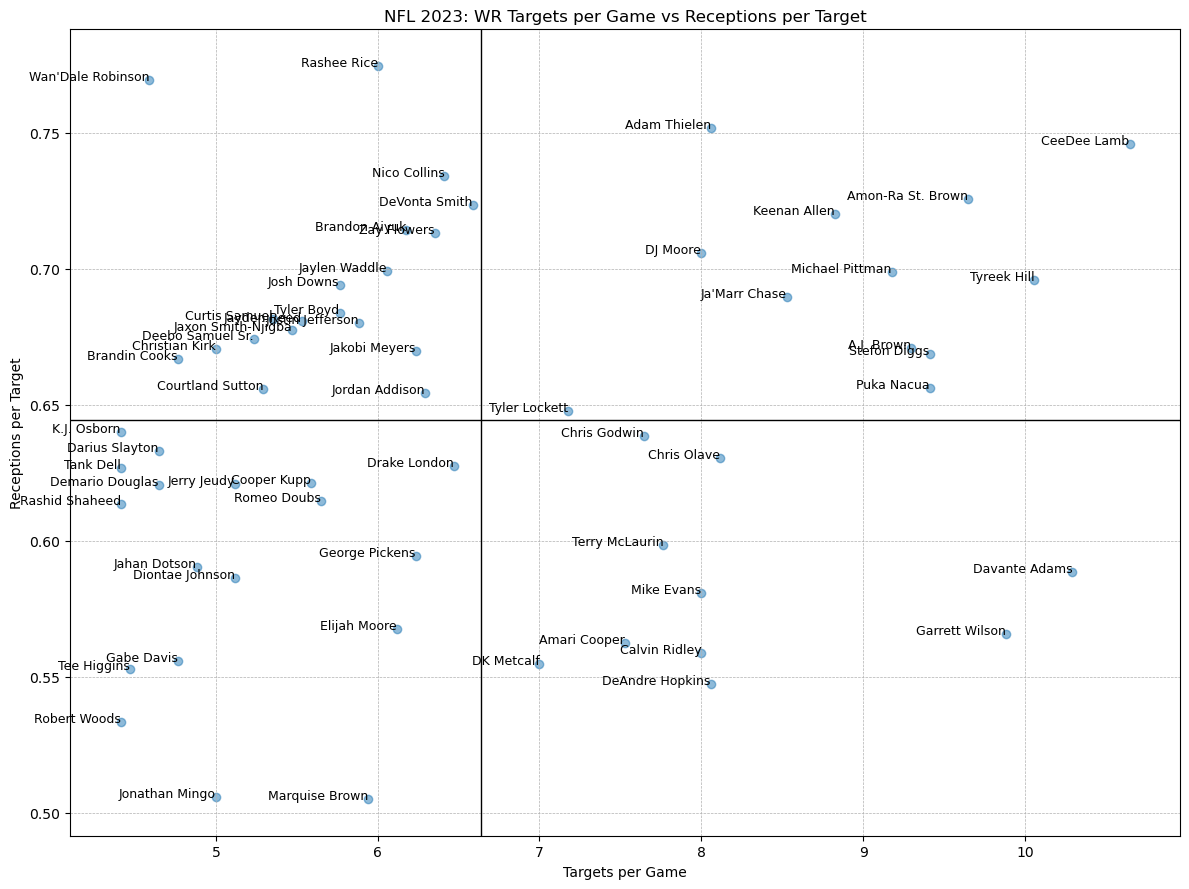

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))

ax.scatter(wr_receiving_df_parsed['Tgts'] / 17, wr_receiving_df_parsed['Rec'] / wr_receiving_df_parsed['Tgts'], alpha=0.5)

for index, row in wr_receiving_df_parsed.iterrows():
    plt.text(row['Tgts'] / 17, row['Rec'] / row['Tgts'], row['Player'], fontsize=9, ha='right')

x_mean = (wr_receiving_df_parsed['Tgts'] / 17).mean()
y_mean = (wr_receiving_df_parsed['Rec'] / wr_receiving_df_parsed['Tgts']).mean()
ax.axvline(x=x_mean, color='black', linestyle='solid', linewidth=1)
ax.axhline(y=y_mean, color='black', linestyle='solid', linewidth=1)

ax.grid(True, which='both', axis='both', linewidth=0.5, linestyle='--')

plt.title('NFL 2023: WR Targets per Game vs Receptions per Target')
plt.xlabel('Targets per Game')
plt.ylabel('Receptions per Target')
plt.tight_layout()

Text(0, 0.5, 'TDs per Reception')

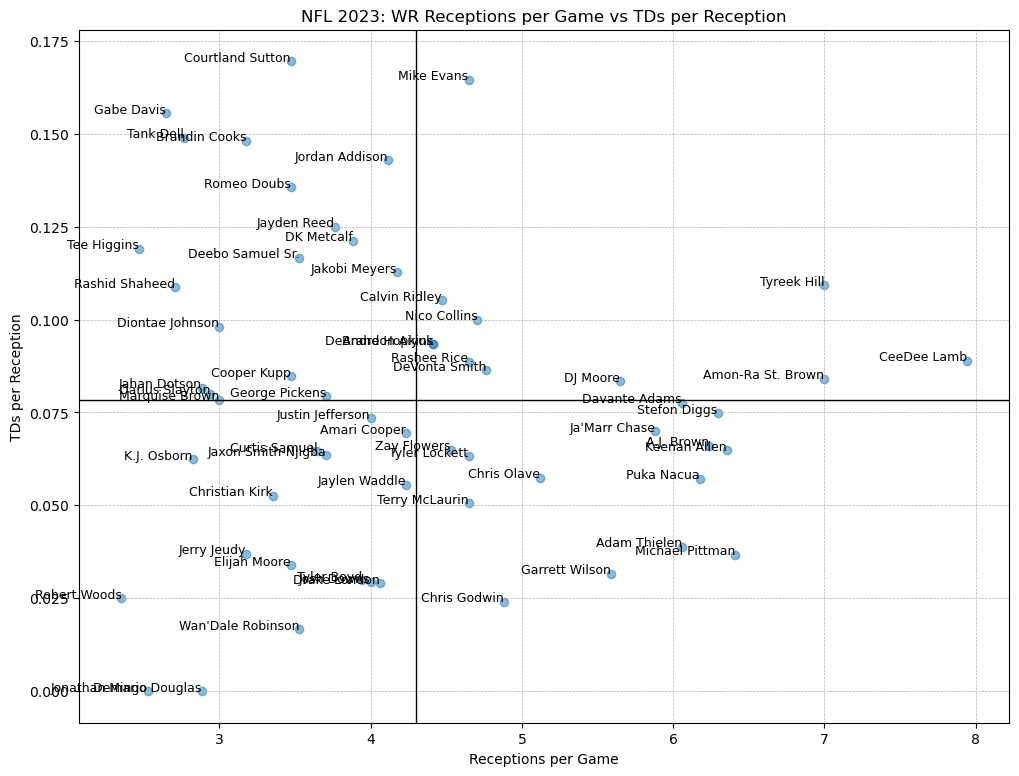

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))

ax.scatter(wr_receiving_df_parsed['Rec'] / 17, wr_receiving_df_parsed['TD'] / wr_receiving_df_parsed['Rec'], alpha=0.5)

for index, row in wr_receiving_df_parsed.iterrows():
    plt.text(row['Rec'] / 17, row['TD'] / row['Rec'], row['Player'], fontsize=9, ha='right')

x_mean = (wr_receiving_df_parsed['Rec'] / 17).mean()
y_mean = (wr_receiving_df_parsed['TD'] / wr_receiving_df_parsed['Rec']).mean()
ax.axvline(x=x_mean, color='black', linestyle='solid', linewidth=1)
ax.axhline(y=y_mean, color='black', linestyle='solid', linewidth=1)

ax.grid(True, which='both', axis='both', linewidth=0.5, linestyle='--')

plt.title('NFL 2023: WR Receptions per Game vs TDs per Reception')
plt.xlabel('Receptions per Game')
plt.ylabel('TDs per Reception')

In [ ]:
rb_pos_id = positions_df.loc[positions_df['POS'] == 'WR', 'pos_id'].iloc[0]
rb_receiving_df_parsed = receiving_df[(receiving_df['Tgts'] > 10) & (receiving_df['Pos'] == rb_pos_id)]
rb_rushing_df_parsed = rushing_df[(rushing_df['Att'] > 10) & (rushing_df['Pos'] == rb_pos_id)]